In [1]:
import numpy as np
from skimage import io,color
import cv2 as cv
from scipy.signal import convolve2d
from matplotlib import pyplot as plt
from skimage.filters import gaussian

In [2]:
def make_correction(channel:np.ndarray,mu:float)->np.ndarray:
    channel=channel/255.0
    channel_mean=channel.mean()
    channel_var=channel.var()
    channel_max=channel_mean+mu*channel_var
    channel_min=channel_mean-mu*channel_var
    channel_corrected=255.0*(channel-channel_min)/(channel_max-channel_min)
    channel_corrected=np.clip(channel_corrected,0,255)
    return channel_corrected.astype(np.uint8)

In [3]:
def shrink(x:np.ndarray,eps:float)->float:
    norm=np.linalg.norm(x,ord=2)
    if norm ==0:
        return np.zeros(shape=x.shape)
    ans=x*np.max(norm-eps,0)/norm
    return ans

In [4]:
def get_corrected_image(img:np.ndarray,mu:float)->np.ndarray:
    R,G,B=img[:,:,0],img[:,:,1],img[:,:,2]
    R_corrected,G_corrected,B_corrected=make_correction(R,mu),make_correction(G,mu),make_correction(B,mu)
    corrected_image=np.stack([R_corrected,G_corrected,B_corrected],axis=-1)
    return corrected_image


In [5]:
def RGB2LAB(img:np.ndarray)->tuple[np.ndarray]:
    lab_img=color.rgb2lab(img)
    L,A,B=lab_img[:,:,0],lab_img[:,:,1],lab_img[:,:,2]
    return (L,A,B)

In [6]:
def initialize_RI(L_channel:np.ndarray)->tuple[np.ndarray]:
    height,width=L_channel.shape[0],L_channel.shape[1]
    R=np.zeros(shape=(height,width))
    I0=gaussian(L_channel)
    return (R,I0)

In [7]:
KERNEL_X=np.array([[-1,1]])
KERNEL_Y=np.array([[-1],[1]])

In [8]:
def gradient_x(img:np.ndarray)->np.ndarray:
    kernel_x=np.abs(convolve2d(img,KERNEL_X,mode='same'))
    return np.uint8(kernel_x)

In [9]:
def gradient_y(img:np.ndarray)->np.ndarray:
    kernel_y=np.abs(convolve2d(img,KERNEL_Y,mode='same'))
    return np.uint8(kernel_y)

In [10]:
# delta denotes lambda in original paper we can not use lambda as variable because it is a reserved keyword in python language
def optimizer(R:np.ndarray,I:np.ndarray,I0:np.ndarray,L:np.ndarray,d:np.ndarray,alpha:float=100,beta:float=0.1,gamma:float=1,delta:float=10)->float:
    penalty1=(np.linalg.norm(R*I-L,ord=2))**2
    penalty2=(alpha*(np.linalg.norm(np.vstack((gradient_x(I),gradient_y(I))),ord=2))**2)
    penalty3=(delta*(np.linalg.norm(np.vstack((gradient_x(R),gradient_y(R)))-d,ord=2))**2)
    penalty3=beta*(penalty3+np.linalg.norm(d,ord=1))
    penalty4=gamma*(np.linalg.norm(I-I0,ord=2))**2
    return (penalty1+penalty2+penalty3+penalty4)

In [11]:
def update_d(R:np.ndarray,delta:float=10)->np.ndarray:
    d_x=shrink(gradient_x(R),1.0/2*delta)
    d_y=shrink(gradient_y(R),1.0/2*delta)
    return np.vstack((d_x,d_y))

In [12]:
def denom(D_x:np.ndarray=KERNEL_X,D_y:np.ndarray=KERNEL_Y)->np.ndarray:
    fft_d_x=np.fft.fft(D_x)
    conjugate_fft_d_x=np.conjugate(fft_d_x)
    fft_d_y=np.fft.fft(D_y)
    conjugate_fft_d_y=np.conjugate(fft_d_y)
    return (fft_d_x.dot(conjugate_fft_d_x.T)).squeeze()+(fft_d_y.T.dot(conjugate_fft_d_y)).squeeze()

In [13]:
def update_R(L:np.ndarray,I:np.ndarray,beta:float=0.1,delta:float=10)->np.ndarray:
    numerator=(1+beta*delta)*np.fft.fft(L/I)
    denominator=(np.fft.fft([1])+beta*delta*denom())
    return (np.fft.ifft(numerator/denominator)).real
    

In [14]:
def update_I(I0:np.ndarray,L:np.ndarray,R:np.ndarray,alpha:float=100,gamma:float=1)->np.ndarray:
    numerator=np.fft.fft(gamma*I0+L/R)
    denominator=(np.fft.fft([1+gamma])+alpha*denom())
    return (np.fft.ifft(numerator/denominator)).real

In [15]:
def enhance_R(R:np.ndarray)->np.ndarray:
    clahe=cv.createCLAHE(clipLimit=2,tileGridSize=(8,8))
    clahe_result=clahe.apply(R)
    return clahe_result

In [28]:
def LAB2RGB(L:np.ndarray,A:np.ndarray,B:np.ndarray)->np.ndarray:
    LAB_IMAGE=np.hstack([L,A,B])
    image=color.lab2rgb(LAB_IMAGE)
    return image

In [17]:
image=io.imread("../images/d_r_144_.jpg")

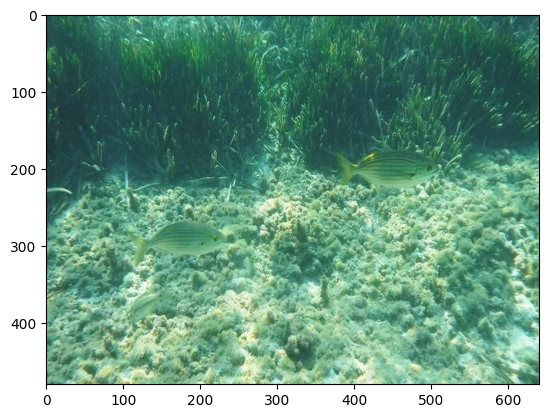

In [18]:
plt.imshow(image)
plt.show()

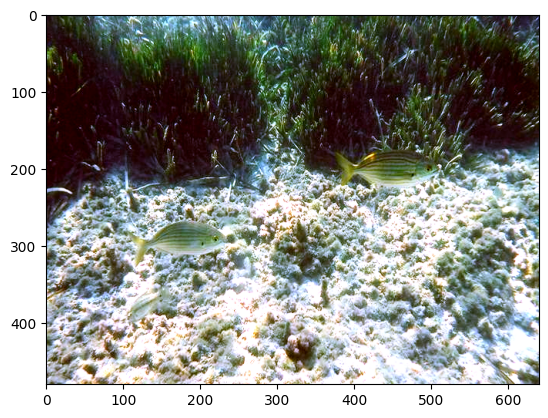

In [68]:
corrected_image=get_corrected_image(image,7)
plt.imshow(corrected_image)
plt.show()

In [69]:
L,A,B=RGB2LAB(corrected_image)

In [70]:
R,Io=initialize_RI(L)

In [71]:
I=gaussian(L)
print(I)

[[ 9.09858655  7.56364906  6.53137866 ... 17.670284   19.25360738
  19.29707046]
 [10.63092196  8.78762075  7.33614564 ... 17.5177816  18.40849703
  19.1877655 ]
 [11.95514459  9.84536088  7.97798806 ... 17.15457907 18.32994648
  20.46280167]
 ...
 [54.09660719 59.54274361 65.78612664 ... 23.43652216 26.46511606
  29.00014697]
 [56.3113999  61.04961007 65.59656719 ... 25.79623661 28.47323131
  30.39175422]
 [60.75243993 64.22441583 66.52517253 ... 27.77412059 30.09241211
  31.43172744]]


In [72]:
denom()

(6+0j)

In [73]:
beta:float=0.1
delta:float=10

In [74]:
numerator=(1+beta*delta)*np.fft.fft(L/I)

In [75]:
L,I

(array([[ 9.13393532,  6.34120407,  4.91090034, ..., 17.83264336,
         22.59442036, 18.16236318],
        [11.85168559,  8.27361197,  6.54353932, ..., 19.68976343,
         18.16236318, 20.98220438],
        [14.65597831, 10.11775922,  7.49333982, ..., 19.68976343,
         10.58591033, 17.79151627],
        ...,
        [50.54343445, 57.79040159, 67.498872  , ..., 21.83479962,
         26.09845566, 30.50430821],
        [49.37629934, 57.79040159, 68.00538624, ..., 26.09845566,
         29.20590084, 31.45391616],
        [62.58657845, 67.40943556, 71.02640495, ..., 29.60956896,
         31.45391616, 32.34151182]]),
 array([[ 9.09858655,  7.56364906,  6.53137866, ..., 17.670284  ,
         19.25360738, 19.29707046],
        [10.63092196,  8.78762075,  7.33614564, ..., 17.5177816 ,
         18.40849703, 19.1877655 ],
        [11.95514459,  9.84536088,  7.97798806, ..., 17.15457907,
         18.32994648, 20.46280167],
        ...,
        [54.09660719, 59.54274361, 65.78612664, ..., 2

In [76]:
denominator=(np.fft.fft([1])+beta*delta*denom())

In [77]:
denominator

array([7.+0.j])

In [78]:
L_up=np.fft.ifft(numerator/denominator)

In [79]:
R=L_up.real

In [80]:
alpha:float=100
gamma:float=1

In [81]:
numerator=np.fft.fft(gamma*Io+L/R)

C:\Users\rahim\AppData\Local\Temp\ipykernel_6264\3850006087.py:1: RuntimeWarning: invalid value encountered in divide
  numerator=np.fft.fft(gamma*Io+L/R)


In [57]:
denominator=(np.fft.fft([1+gamma])+alpha*denom())

In [60]:
I=np.fft.ifft(numerator/denominator).real